## Лабортаторная работа №1

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  

##### Цель работы:
Исследование свойств персептрона Розенблантта и его применение для решщения задачи распознавания образов

In [2]:
import numpy as np
import pylab

import torch
import torch.nn as nn

### Задание 1.

Построить и обучить сеть, которая будет правильно относить точки к двум классам.   
Отобразить дискриминационную линию и проверить качество обучения.

Используем такую модель:

In [2]:
model = torch.nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid(),
    nn.Flatten(0,1)
)

2 входных канала потому что две координаты, 1 выходной предсказывает класс, 1 - первый класс, 0 - нулевой  
Порог будет равен 0.5  
В конце применяется flatten, чтобы бинарная кросс-энтропия работала

In [3]:
for a in model.parameters():
    print(a)

Parameter containing:
tensor([[0.0971, 0.0314]], requires_grad=True)
Parameter containing:
tensor([-0.5362], requires_grad=True)


Видим параметры, которые можно будет использовать для построения дискриминанты

обучающая функция:

In [4]:
def accuracy_bin(testRS,testLB):
    return ((model(larrXX).detach().numpy() > 0.5).reshape(larrLB.shape) == np.array(larrLB.numpy(),dtype = np.int32)).mean()

def accuracy_mult(testRS,testLB):
    return (np.argmax(testRS,axis = 1) == testLB.numpy()).mean()

def train(net,trainXX,trainLB,n_epochs,lr, #функция общая на оба задания, меняются применяемые функции оценки точности и функции потерь
         optimiser = torch.optim.SGD,
         criterion = torch.nn.functional.binary_cross_entropy,
         accuracy = accuracy_mult
         ):
    #функция, производящая обучение сети
    #так как весь датасет - 6 элементов, разбиение на батчи не делается
    
    optim = optimiser(model.parameters(),lr=lr)
    
    arr = []
    for i in range(n_epochs):
        optim.zero_grad()
        loss = criterion(model(trainXX),trainLB)
        loss.backward()
        optim.step()
        
        #трэйсинг обучения
        
        arr.append([i,
                    loss.detach().numpy(), #значение ф-и потерь
                    accuracy(model(trainXX).detach().numpy(),trainLB)]) #среднее количество совпадений в предсказаниях (точность)
                    
    return np.array(arr)

In [5]:
def plot_learning(arr):
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("loss",color = "grey")
    pylab.plot(arr[:,0],arr[:,1])
    pylab.show()

    pylab.axis([0,arr.shape[0] - 1,0,1])
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("accuracy",color = "grey")
    pylab.plot(arr[:,0],arr[:,2])
    pylab.show()

In [6]:
larrXX = torch.tensor([(-3.9,-0.1),(4.5,-1.6),(0.8,-2.8),(2.5,-2.5),(0,1.9),(3.9,4.5)],dtype=torch.float32)
larrLB = torch.tensor([0,1,0,0,0,1],dtype=torch.float)

##### Обучнеине модели

In [19]:
model = torch.nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid(),
    nn.Flatten(0,1)
)

arr = train(model,larrXX,larrLB,100,0.1,accuracy = accuracy_bin)
print("accuracy: {}".format(accuracy_bin(model(larrXX).detach().numpy(),larrLB)))

accuracy: 1.0


Кривые обучения:

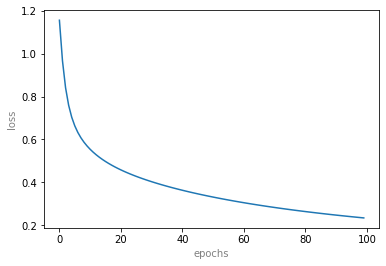

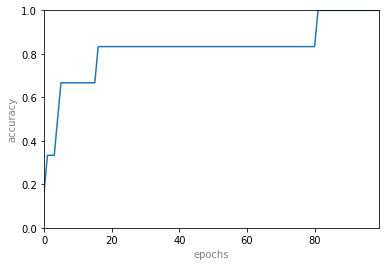

In [20]:
plot_learning(arr)

In [21]:
model(larrXX)

tensor([0.0156, 0.7802, 0.1092, 0.3352, 0.4476, 0.9827],
       grad_fn=<ReshapeAliasBackward0>)

##### Построение дискриминанты

In [22]:
for a in model.parameters():
    print(a)

Parameter containing:
tensor([[0.7385, 0.5274]], requires_grad=True)
Parameter containing:
tensor([-1.2126], requires_grad=True)


извлечение параметров

In [23]:
params = []
for a in model.parameters():
    b = a.detach().numpy()
    params.append(b[0])
    
w = [params[0][0],
     params[0][1],
     params[1]]

print(w)

[0.73852354, 0.5274134, -1.2126034]


In [24]:
lb0 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 0])
lb1 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 1])

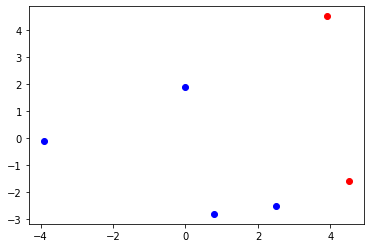

In [25]:
pylab.plot(lb0[:,0],lb0[:,1],'bo' )
pylab.plot(lb1[:,0],lb1[:,1],'ro' )
pylab.show()

In [26]:
def plot_boundary(positive_examples, negative_examples, weights):
    upper = 0
    lower = 0
    for a in positive_examples:
        if a[0] > upper:
            upper = a[0] + 1
        if a[1] > upper:
            upper = a[1] + 1
    
    for a in negative_examples:
        if a[0] > upper:
            upper = a[0] + 1
        if a[1] > upper:
            upper = a[1] + 1
            
    
    for a in positive_examples:
        if a[0] < lower:
            lower = a[0] - 1
        if a[1] < lower:
            lower = a[1] - 1
    
    for a in negative_examples:
        if a[0] < lower:
            lower = a[0] - 1
        if a[1] < lower:
            lower = a[1] - 1
            

    x = np.array([lower, upper], dtype='float32')
    y = -(weights[0] * x + weights[2])/weights[1]

    pylab.axis([lower, upper,lower, upper])                     
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

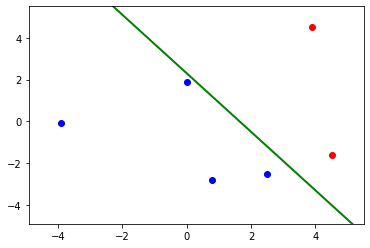

In [27]:
plot_boundary(lb0,lb1,w)

###### Линейно неразделимая выборка

Добавим один элемент, относящийся к классу 1, который нельзя отделить линией от класса 0

In [63]:
larrXX = torch.tensor([(-3.9,-0.1),(4.5,-1.6),(0.8,-2.8),(2.5,-2.5),(0,1.9),(3.9,4.5),(0,0)],dtype=torch.float32)
larrLB = torch.tensor([0,1,0,0,0,1,1],dtype=torch.float)

In [65]:
lb0 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 0])
lb1 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 1])

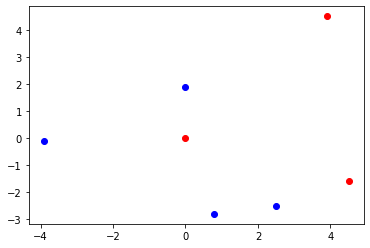

In [66]:
pylab.plot(lb0[:,0],lb0[:,1],'bo' )
pylab.plot(lb1[:,0],lb1[:,1],'ro' )
pylab.show()

In [77]:
model = torch.nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid(),
    nn.Flatten(0,1)
)

arr = train(model,larrXX,larrLB,100,0.1,accuracy = accuracy_bin)
print("accuracy: {}".format(accuracy_bin(model(larrXX).detach().numpy(),larrLB)))

accuracy: 0.7142857142857143


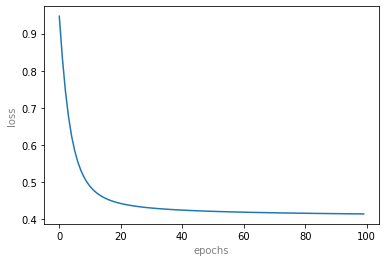

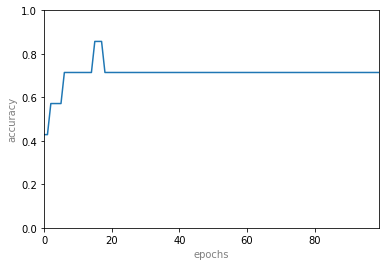

In [78]:
plot_learning(arr)

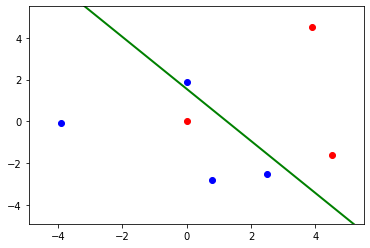

In [79]:
params = []
for a in model.parameters():
    b = a.detach().numpy()
    params.append(b[0])
    
w = [params[0][0],
     params[0][1],
     params[1]]

plot_boundary(lb0,lb1,w)

### Задание 2.

Построить и обучить сеть, которая будет правильно относить точки к четырем классам.   
Отобразить дискриминантную линию и проверить качество обучения.

В этом задании вывод модели - это массив из четырех чисел, каждое из которых - вероятность отношения классифициручемого объекта к соответствующему классу.

In [62]:
larrXX = torch.tensor([(3.9,-4.1),(-4.6,0.5),(2.7,-1.9),(-3.3,-1.7),(-2.9,0.1),(4,1.2),(-4,-1.1),(-4.5,0)],dtype=torch.float32)
larrLB = torch.tensor([1,2,1,0,2,3,0,2],dtype=torch.long)

##### Обучнеине модели

In [63]:
model = torch.nn.Sequential(
    nn.Linear(2,4),
    nn.Softmax(dim = 1)
)

arr = train(model,larrXX,larrLB,500,0.1,
           criterion = torch.nn.CrossEntropyLoss(),accuracy = accuracy_mult)
print(accuracy_mult(model(larrXX).detach().numpy(),larrLB))

1.0


Кривые обучения:

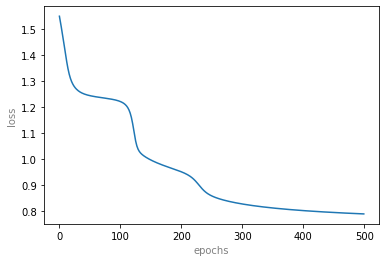

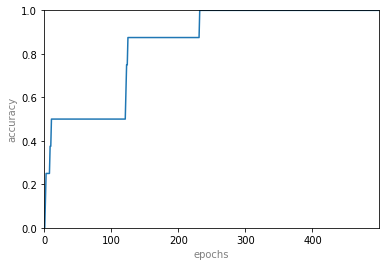

In [64]:
plot_learning(arr)

In [85]:
model(larrXX)

tensor([[9.9797e-03, 9.8985e-01, 6.6535e-09, 1.7059e-04],
        [2.2731e-02, 6.2182e-05, 9.7713e-01, 7.3269e-05],
        [2.2255e-02, 9.5816e-01, 1.9382e-05, 1.9570e-02],
        [9.6276e-01, 7.0221e-03, 3.0146e-02, 7.1173e-05],
        [1.5090e-01, 4.1873e-03, 8.4216e-01, 2.7549e-03],
        [3.0350e-05, 3.1867e-02, 1.4683e-04, 9.6796e-01],
        [7.8728e-01, 2.6528e-03, 2.0998e-01, 9.2034e-05],
        [9.8276e-02, 2.5250e-04, 9.0137e-01, 9.7220e-05]],
       grad_fn=<SoftmaxBackward0>)

In [98]:
np.sum(model(larrXX).detach().numpy(),axis = 1)

array([0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 0.99999994], dtype=float32)

Отображение точек:

In [65]:
lb0 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 0])
lb1 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 1])
lb2 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 2])
lb3 = np.array([[larrXX[i][0],larrXX[i][1]] for i in range(len(larrXX)) 
 if larrLB[i] == 3])

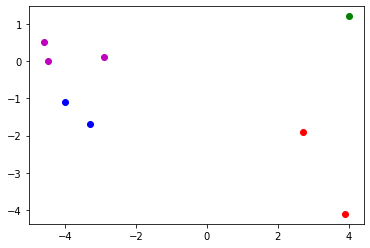

In [66]:
pylab.plot(lb0[:,0],lb0[:,1],'bo' )
pylab.plot(lb1[:,0],lb1[:,1],'ro' )
pylab.plot(lb2[:,0],lb2[:,1],'mo' )
pylab.plot(lb3[:,0],lb3[:,1],'go' )
pylab.show()

In [67]:
for a in model.parameters():
    print(a)

Parameter containing:
tensor([[-0.8211, -1.4879],
        [ 0.5755, -1.3325],
        [-1.2452,  2.0164],
        [ 1.0435,  0.6707]], requires_grad=True)
Parameter containing:
tensor([ 0.0690,  0.5210,  0.5797, -0.4973], requires_grad=True)


In [68]:
params = []
w = []

for a in model.parameters():
    b = a.detach().numpy()
    params.append(b)
    
w.append(
    [params[0][0][0],
     params[0][0][1],
     params[1][0]])
w.append(
    [params[0][1][0],
     params[0][1][1],
     params[1][1]])
w.append(
    [params[0][2][0],
     params[0][2][1],
     params[1][2]])
w.append(
    [params[0][3][0],
     params[0][3][1],
     params[1][3]])

In [69]:
def add_boundary(weights,color = "green"):            

    x = np.array([-5, 5], dtype='float32')
    y = -(weights[0] * x + weights[2])/weights[1]

    pylab.plot(x, y, linewidth=2.0,color = color)

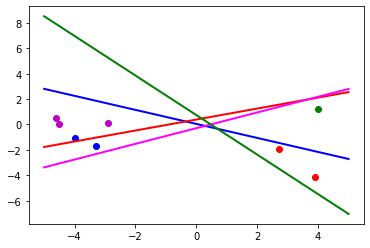

In [70]:
pylab.plot(lb0[:,0],lb0[:,1],'bo' )
pylab.plot(lb1[:,0],lb1[:,1],'ro' )
pylab.plot(lb2[:,0],lb2[:,1],'mo' )
pylab.plot(lb3[:,0],lb3[:,1],'go' )

add_boundary(w[0],"blue")
add_boundary(w[1],"red")
add_boundary(w[2],"magenta")
add_boundary(w[3],"green")

pylab.show()

### Вывод

В ходе выполнения этой лабораторной работы я ознакомился с принципами работы персептрона и получил опыт в реализации бинарной и многоклассовой классификации. Возможность неспешно поработать с простыми нейронными сетями позволила мне на практике понять, как на обучаемость сети влияет функция активации.